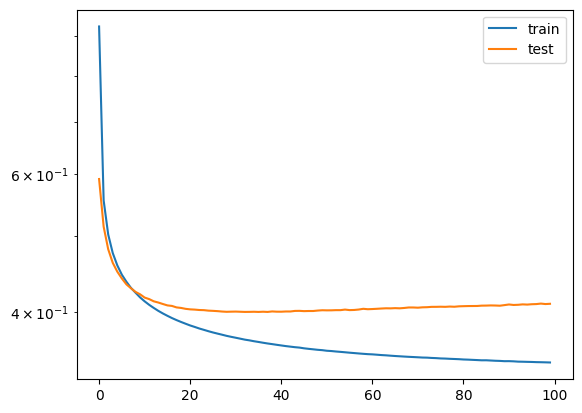

lowest test at epoch 35 with loss 0.39949986046077285


In [1]:
import matplotlib.pyplot as plt, json
import pathlib

json_file = "../saved_models/model_preCondRNN_v4.2/losses.json"
pathlib.Path(json_file).parent.mkdir(parents=True, exist_ok=True)

log = json.load(open(json_file))

train_losses = [l["ce_train"] for l in log]
test_losses = [l["ce_test"] for l in log]

plt.plot(train_losses, label='train')
plt.plot(test_losses,  label='test')
plt.yscale('log'); plt.legend(); plt.show()

print(f"lowest test at epoch {test_losses.index(min(test_losses))} with loss {min(test_losses)}")


## Loading Best model

In [2]:
from visualize_latent_space import load_model_from_folder
import torch

folder = "../saved_models/model_preCondRNN_v4.2"
model, vocab, train_args = load_model_from_folder(folder)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

/home/meconcelli/miniconda3/envs/cacca_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading vocabulary from ../saved_models/model_preCondRNN_v4.2/vocab.pkl …
[INFO] Loading VAE model from ../saved_models/model_preCondRNN_v4.2/model_best.pt …


ConditionalAutoencoder(
  (embedding): Embedding(36, 256)
  (encoder_rnn): LSTM(261, 512, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (to_latent): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=512, out_features=200, bias=True)
  )
  (latent_to_decoder_hidden): Linear(in_features=200, out_features=1536, bias=True)
  (decoder_rnn): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.1)
  (output_to_vocab): Linear(in_features=512, out_features=36, bias=True)
  (property_predictor): Sequential(
    (0): Linear(in_features=200, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=5, bias=True)
  )
)

## Loading test_loader

In [3]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os

# ---
from utils.data_utils import load_preprocessed_data, SmilesDataset


prop_file = os.path.join("..", train_args.prop_file)
max_seq_length = train_args.max_seq_length
training_percent = train_args.training_percent
batch_size = train_args.batch_size
seed = train_args.seed


# --- Load data from SMILES+properties file ---
processed_data = load_preprocessed_data(prop_file, max_seq_length=max_seq_length)
pytorch_dataset = SmilesDataset(processed_data)



# split the dataset into train and test sets
num_total = len(pytorch_dataset)
num_train = int(num_total * training_percent)

train_dataset, test_dataset = train_test_split(
    pytorch_dataset, train_size=num_train, shuffle=True, random_state=seed
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)


📖  Caricamento dati da: smiles_preprocessed_scale-zscore.csv
    -> Trovate 500004 molecole valide.
    -> Creato vocabolario con 36 caratteri.


In [38]:
from sklearn.metrics import r2_score
Z, y_true, y_pred = [], [], []
for data in test_loader:
    with torch.no_grad():
        z, _, c_hat = model(data["input"].to(device),
                            data["properties"].to(device),
                            data["length"].to(device))
    y_true.append(data["properties"])
    y_pred.append(c_hat.cpu())
y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()
print("R2 per colonna:", r2_score(y_true, y_pred, multioutput='raw_values'))

R2 per colonna: [0.9981755  0.9977068  0.99896985 0.9956312  0.99669164]


In [4]:
# load mol from mol_test.csv
from pathlib import Path
import json
# ---
from visualize_latent_space import load_smiles_from_csv, smiles_dict_to_tensor

molecules_df = load_smiles_from_csv("../assets/mol_test.csv")
x, c, l, logp_vals, valid_smiles, names, paper_vals = smiles_dict_to_tensor(molecules_df, vocab, train_args.max_seq_length)
x, c, l = x.to(device), c.to(device), l.to(device)
smiles_scale_file = "../dataset/ZINC_with_drugs/smiles_preprocessed_scale-zscore_scaling_metrics.json"

    # load dataset scale metric from json file
scale_file = Path(smiles_scale_file)
if scale_file.exists():
    with open(scale_file) as f:
        scale_data = json.load(f)
        print(f"[INFO] Loaded scaling metrics from {scale_file.as_posix()}")
        if scale_data["Scaling method"] == "zscore":
            scale_metrics = scale_data['Scale metrics']
            mean = torch.tensor(scale_metrics[0], device=device, dtype=torch.float32)
            std = torch.tensor(scale_metrics[1], device=device, dtype=torch.float32)
            c = (c - mean) / std
            
with torch.no_grad():
    latent = model(x, c, l)[0].cpu().numpy()
    print(f"[INFO] Encoded {latent.shape[0]} molecules → latent_dim={latent.shape[1]}")
    

[INFO] Loaded scaling metrics from ../dataset/ZINC_with_drugs/smiles_preprocessed_scale-zscore_scaling_metrics.json
[INFO] Encoded 32 molecules → latent_dim=200


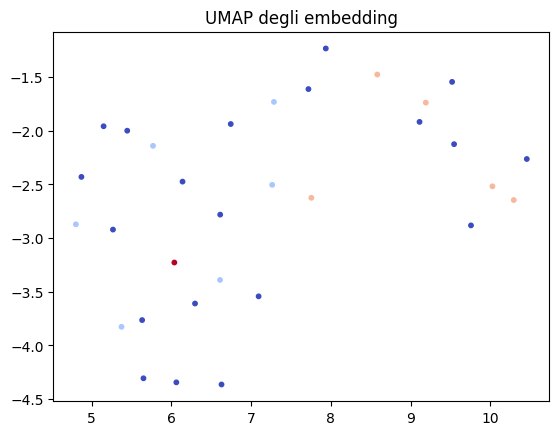

In [5]:
import umap, matplotlib.pyplot as plt
Z = latent      # (N, d)
labels = paper_vals 
Z2 = umap.UMAP(metric='cosine').fit_transform(Z)
plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=10, cmap='coolwarm')
plt.title('UMAP degli embedding')
plt.show()

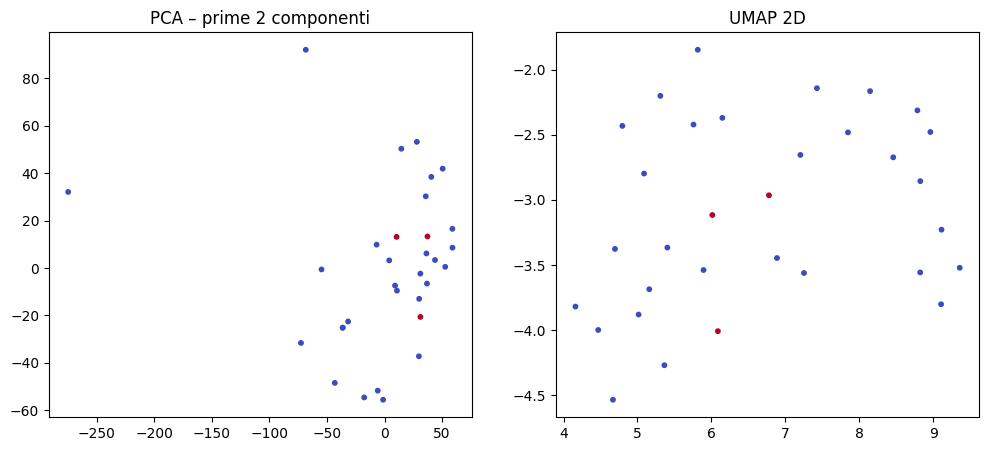

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt


labels = [1 if "POLY" in name else 0 for name in names]
Z_pca = PCA(n_components=3).fit_transform(Z)
Z_umap = umap.UMAP(n_components=2, metric='cosine').fit_transform(Z)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].scatter(Z_pca[:,0], Z_pca[:,1], c=labels, s=10, cmap='coolwarm')
ax[0].set_title('PCA – prime 2 componenti')

ax[1].scatter(Z_umap[:,0], Z_umap[:,1], c=labels, s=10, cmap='coolwarm')
ax[1].set_title('UMAP 2D')
plt.show()

In [7]:
# Correlazione dimensione-proprietà

import pandas as pd
import seaborn as sns

df = pd.DataFrame(Z, columns=[f'z{i}' for i in range(Z.shape[1])])
df['logP'] = logp_vals         # proprietà note
corr = df.corr()['logP'].abs().sort_values(ascending=False)[:10]
print(corr)

# Dimensioni con |ρ| alto mostrano disentanglement; puoi regolare β-VAE o FiLM se vedi che l’informazione si disperde.

logP    1.000000
z124    0.950022
z26     0.925605
z30     0.920449
z154    0.900736
z31     0.889796
z166    0.877819
z199    0.873468
z188    0.861483
z47     0.856183
Name: logP, dtype: float64


In [10]:
from rdkit import Chem
def is_valid(smi): return Chem.MolFromSmiles(smi) is not None

N = 1000
valid, uniq = 0, set()
print(vocab)
start_token = "X"
eos_idx = "E"

def detokenize(token_indices):
    # token_indices: list or tensor of token indices
    # Convert indices to tokens using vocab (reverse mapping)
    idx_to_token = {v: k for k, v in vocab.items()}
    if hasattr(token_indices, 'tolist'):
        token_indices = token_indices.tolist()
    tokens = [idx_to_token[idx] for idx in token_indices if idx in idx_to_token]
    # Remove start_token and everything after eos_idx
    if start_token in tokens:
        tokens = tokens[tokens.index(start_token)+1:]
    if eos_idx in tokens:
        tokens = tokens[:tokens.index(eos_idx)]
    return ''.join(tokens)

for _ in range(N):
    z = torch.randn(1, model.latent_size).to(device)
    c = torch.zeros(1, model.num_prop).to(device)       
    toks = model.sample(z, c, start_token, eos_idx, top_k=50, temperature=0.8)
    smi  = detokenize(toks[0])
    if is_valid(smi): valid += 1
    uniq.add(smi)
print(f"Validity {valid/N:.3f},  Uniqueness {len(uniq)/valid if valid else 0:.3f}")

{'_': 0, 'X': 1, 'E': 2, '#': 3, '(': 4, ')': 5, '+': 6, '-': 7, '/': 8, '1': 9, '2': 10, '3': 11, '4': 12, '5': 13, '6': 14, '7': 15, '=': 16, '@': 17, 'B': 18, 'C': 19, 'F': 20, 'H': 21, 'I': 22, 'N': 23, 'O': 24, 'P': 25, 'S': 26, '[': 27, '\\': 28, ']': 29, 'c': 30, 'l': 31, 'n': 32, 'o': 33, 'r': 34, 's': 35}


AttributeError: 'str' object has no attribute 'to'

In [8]:
import numpy as np, sklearn                        # (N, d)
props = c.cpu().numpy()              
print(props.shape)# (N, 5)
for j, name in enumerate(["ExactMW", "LogP", "NumHBD", "NumHBA", "TPSA"]):
    r2 = sklearn.linear_model.LinearRegression().fit(Z, props[:,j]).score(Z, props[:,j])
    print(name, r2)
    

    
# Se vedi R² > 0.9 per (quasi) tutti i j significa che z ≈ funzione lineare delle proprietà → povera di informazione strutturale.

(32, 5)
ExactMW 1.0
LogP 1.0
NumHBD 1.0
NumHBA 1.0
TPSA 1.0


In [5]:
#!/usr/bin/env python3
"""
Calcolo Spearman fra distanze chimiche (fingerprint),
distanze in spazio latente del CAE e (opz.) distanze sulle proprietà.

Richiede:
  • pandas, numpy, scipy, rdkit, torch
  • le tue funzioni: load_smiles_from_csv, smiles_dict_to_tensor, model, vocab, train_args
"""

import json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from tqdm import tqdm
from rdkit.Chem import Descriptors, rdMolDescriptors



PAD, EOS, SOS = "_", "E", "X"  # special tokens expected by the model


def smiles_dict_to_tensor(
    smiles_df: pd.DataFrame,  # MODIFICA: Accetta un DataFrame
    char2idx: dict[str, int],
    seq_length: int,):  # MODIFICA: Aggiunto List[int] per i valori di 'PAPER'
    """
    MODIFICA: Processa un DataFrame invece di un dizionario.
    Restituisce anche i valori della colonna 'PAPER'.
    """
    xs, cs, ls, valid_smiles, logp_vals, names, paper_vals = [], [], [], [], [], [], []

    # MODIFICA: Itera sulle righe del DataFrame
    for row in smiles_df.itertuples():
        smi = row.SMILES

        mol = Chem.MolFromSmiles(smi)
        if mol is None or len(smi) >= seq_length - 2:
            print(f"[WARN] Skipping invalid or too‑long SMILES: {smi}")
            continue

        mw = Descriptors.ExactMolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = rdMolDescriptors.CalcNumHBD(mol)
        hba = rdMolDescriptors.CalcNumHBA(mol)
        tpsa = rdMolDescriptors.CalcTPSA(mol)

        logp_vals.append(logp)

        token_ids = [char2idx.get(ch) for ch in smi if ch in char2idx]
        if not token_ids:
            print(f"[WARN] Skipping SMILES with no recognised chars: {smi} (name: {name})")
            continue

        padded = [char2idx[SOS]] + token_ids + [char2idx[EOS]] * (seq_length - len(token_ids) - 1)
        xs.append(padded)
        cs.append([mw, logp, hbd, hba, tpsa])
        ls.append(len(token_ids) + 1)  # +1 for SOS
        valid_smiles.append(smi)

    if not xs:
        raise RuntimeError("No valid SMILES to process – aborting.")

    return (
        torch.as_tensor(xs, dtype=torch.long),
        torch.tensor(cs, dtype=torch.float32),
        torch.as_tensor(ls, dtype=torch.long),
        np.array(logp_vals, dtype=np.float32),
        valid_smiles,
    )

# -------------------------------------------------------------------------
# 0. Parametri da personalizzare
# -------------------------------------------------------------------------
CSV_PATH = "../dataset/ZINC_with_drugs/smiles_preprocessed_scale-zscore.csv"      # file con SMILES + proprietà
SCALE_JSON = "../dataset/ZINC_with_drugs/smiles_preprocessed_scale-zscore_scaling_metrics.json"
FINGERPRINT_BITS = 2048
FP_RADIUS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------------------------------
# 1. Caricamento CSV
# -------------------------------------------------------------------------
df = pd.read_csv(CSV_PATH)
smiles_list = df["SMILES"].tolist()

# -------------------------------------------------------------------------
# 2. Embedding nel CAE
# -------------------------------------------------------------------------
# IMPORTA le tue funzioni / modello. Adatta il path o usa relative import.
from visualize_latent_space import (
    load_smiles_from_csv
)

molecules_df = load_smiles_from_csv(CSV_PATH, n_rows=10000)

# x: sequenza SMILES, c: vettore proprietà condizionali, l: lunghezze
x, c, l, _logp, valid_smiles = smiles_dict_to_tensor(
    molecules_df, vocab, train_args.max_seq_length
)
x, c, l = x.to(DEVICE), c.to(DEVICE), l.to(DEVICE)

# (facoltativo) z-score sul vettore condizionale
scale_file = Path(SCALE_JSON)
if scale_file.exists():
    with open(scale_file) as f:
        scale_data = json.load(f)
    if scale_data.get("Scaling method") == "zscore":
        mean, std = map(torch.tensor, scale_data["Scale metrics"])
        c = (c - mean.to(DEVICE)) / std.to(DEVICE)

with torch.no_grad():
    latent = model(x, c, l)[0].cpu().numpy()        # shape: (N, latent_dim)
print(f"[INFO] Embedding ottenuti: {latent.shape}")

# -------------------------------------------------------------------------
# 3. Fingerprint Tanimoto (DISTANZA = 1 - sim)
# -------------------------------------------------------------------------
fps = [
    AllChem.GetMorganFingerprintAsBitVect(
        Chem.MolFromSmiles(s), radius=FP_RADIUS, nBits=FINGERPRINT_BITS
    )
    for s in tqdm(valid_smiles, desc="> RDKit fingerprint")
]

tan_vec = np.fromiter(
    (DataStructs.TanimotoSimilarity(fps[i], fps[j])
     for i in range(len(fps)) for j in range(i + 1, len(fps))),
    dtype=np.float32
)
d_tan = 1.0 - tan_vec                                   # (N·(N-1)/2,)

# -------------------------------------------------------------------------
# 4. Distanze nel latente (cosine condensed)
# -------------------------------------------------------------------------
d_lat = pdist(latent, metric="cosine")                  # stesso formato

# -------------------------------------------------------------------------
# 5. Spearman ρ  (fingerprint vs latente)
# -------------------------------------------------------------------------
rho_fp, p_fp = spearmanr(d_tan, d_lat)
print(f"\nSpearman ρ  (fingerprint ↔︎ latente) : {rho_fp:.3f}   p = {p_fp:.2e}")

# -------------------------------------------------------------------------
# 6. (Opz.) Distanze su proprietà fisico-chimiche
# -------------------------------------------------------------------------
prop_cols = ["ExactMW", "LogP", "NumHBD", "NumHBA", "TPSA"]
if all(col in df.columns for col in prop_cols):
    props = df.loc[:, prop_cols].to_numpy(dtype=np.float32)
    # z-score per non far dominare le unità di misura
    props = (props - props.mean(0)) / props.std(0)
    d_prop = pdist(props, metric="euclidean")
    rho_prop, p_prop = spearmanr(d_prop, d_lat)
    print(f"Spearman ρ  (physchem  ↔︎ latente) : {rho_prop:.3f}   p = {p_prop:.2e}")
else:
    print("[WARN] Colonne proprietà mancanti, salta Spearman su phys-chem.")

# -------------------------------------------------------------------------
# 7. Baseline random (facoltativa, aiuta l’interpretazione)
# -------------------------------------------------------------------------
rng = np.random.default_rng(69)
shuffled_lat = rng.permutation(latent)
d_lat_shuff = pdist(shuffled_lat, metric="cosine")
rho_rand, _ = spearmanr(d_tan, d_lat_shuff)
print(f"Baseline random ρ (fingerprint ↔︎ latente shuffle) : {rho_rand:.3f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 9.39 GiB. GPU 0 has a total capacity of 23.65 GiB of which 6.79 GiB is free. Process 26705 has 10.90 GiB memory in use. Including non-PyTorch memory, this process has 5.93 GiB memory in use. Of the allocated memory 4.64 GiB is allocated by PyTorch, and 874.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [17]:
import numpy as np, torch, pandas as pd, rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr

########################
# 1. Input
########################
smiles_list = smiles_list        # list/array of SMILES  (N,)

# tensor/ndarray of shape (N, latent_dim)

########################
# 2. Fingerprints
########################
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=2, nBits=2048)
       for smi in smiles_list]

# 3. Calcolo similarità con BulkTanimotoSimilarity
import numpy as np
N = len(fps)  # numero di molecole
tan = np.zeros((N, N), dtype=np.float32)

for i in range(N):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])  # fps[:i] è una lista
    tan[i, :i] = sims
    tan[:i, i] = sims  # simmetria
    
########################
# 3. Latent distances
########################
Z_np = np.asarray(Z, dtype=np.float32)
d_lat = pairwise_distances(Z_np, metric="cosine")   # (N,N)

########################
# 4. Spearman ρ
########################
# vector-ise upper-triangular part
triu = np.triu_indices(N, k=1)
rho, p = spearmanr(1 - tan[triu], d_lat[triu])      # 1-tan = distance

print(f"Spearman ρ = {rho:.3f}  (p = {p:.2e})")

[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerator
[15:46:01] DEPRECATION WARNING: please use MorganGenerat

IndexError: index 32 is out of bounds for axis 0 with size 32

In [48]:
# vettore delle proprietà normalizzate di POLYMER 2
c_poly = torch.tensor(c[-1]).unsqueeze(0).to(device)  
l_poly = torch.tensor(l[-1]).unsqueeze(0).to(device)  
x_poly = x[-1].unsqueeze(0).to(device)  # shape (1, L)

c_zero = torch.zeros_like(c)  # (1, num_prop)

# ==> per tutte le piccole molecole passa SEMPRE c_poly
Z_poly, Z_mols = [], []
with torch.no_grad():
    Z_poly = model(x_poly, c_poly,l_poly)[0]     # (1,d)
    latent = model(x, c_poly.repeat(x.shape[0], 1), l)[0]
                                          # (N,d)

print(Z_poly.shape, latent.shape)

d_new = torch.cdist(Z_poly.cpu(), latent.cpu()).squeeze(0).numpy()
zzz = zip(d_new, names)
d_new_, names_ = zip(*sorted(zzz, key=lambda x: x[0]))
for i in range(len(d_new_)):
    print(f"{d_new_[i]:.3f} {names_[i]}")

torch.Size([1, 200]) torch.Size([32, 200])
0.000 POLYMER 0
0.354 POLYMER 3
0.433 Phthalic_acid
1.000 POLYMER precrop
1.042 Chrysene
1.135 Nimesulide
1.559 sertralina
1.630 Aspirin
1.644 fluoxetina
1.654 paracetamolo
1.721 Metoclopramide
1.737 2-4-5-trichlorophenoxyacetic acid
1.896 Diclofenac
1.904 amoxicillina
1.912 Heteroatoms
1.912 carbamazepina
1.916 Ibuprofen
1.941 Dimethylurea
1.961 Etoricoxib
1.992 Indomethacin
2.004 Pyramidone
2.056 ciprofloxacina
2.108 Oestradiol
2.301 polistirene
4.793 urea
8.342 Benzene
10.364 Cyclohexane
11.866 Acetic acid
11.866 acido acetico
16.146 PVC
47.740 Ethanol
185.144 Polietilene


/tmp/ipykernel_994998/2865426704.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_poly = torch.tensor(c[-1]).unsqueeze(0).to(device)
/tmp/ipykernel_994998/2865426704.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l_poly = torch.tensor(l[-1]).unsqueeze(0).to(device)


PORCO DIO!